# Statistics 301 Case Study Project: DoorDash Dataset
Report by Soham Chakote, Raina Compton, Alex Pan Wang, Jensen Suhenda

STAT 301: Statistical Modeling for Data Science

April 12, 2023

## Introduction (Raina)

## Methods and Results

In [16]:
# Library imports
library(tidyverse)
library(repr)
library(tidymodels)
library(infer)

### Data (Raina)

In [1]:
# Read the data from Github
door_dash <- read_csv("https://raw.githubusercontent.com/SohamChakote/STAT-301-Project/refs/heads/main/doordash.csv")
head(door_dash)

ERROR: Error in read_csv("https://raw.githubusercontent.com/SohamChakote/STAT-301-Project/refs/heads/main/doordash.csv"): could not find function "read_csv"


#### Data Description

The DoorDash data set is an observational data set consiting of a compilation of eight data sets, each showing restaurants within under 30 minutes delivery time to iconic downtown addresses in eight different populous cities in Canada. The locations are Rogers Center, The Montreal Museum of Fine Arts, Calgary Tower, Rogers Place, Parliment Hill, Winnipeg Millennium Library, Vancouver Public Library, and Downtown Brampton BIA for Toronto, Montreal, Calgary, Edmonton, Ottawa, Winnipeg, Vancouver, and Brampton respectively. 

The original data was collected from the DoorDash website with Selenium. The eight data sets were compiled and cleaned by Soham Chakote from Kaggle user Satoshi_S' data set: https://www.kaggle.com/code/satoshiss/clean-restaurant-raw-data. 

The nine variables of data set are as follows:
* `restaurant`: the name of the restaurant
* `url`: the DoorDash url for the restaurant
*   `star`: the star rating (out of 5) for the restaurant at the time of data collection
* `num_reviews`: the number of reviews for the at the time of data collection
* `city`: the city in Canada the restaurant is located in
* `distance_in_meters`: the distance in meters from the restaurant to the respective notable downtown address in each city
* `price_range`: the price range for the restaurant ranging from 1 to 4 (denoted by number of $)

#### Pre-Selection of Variables

We will be dropping both the `restaurant` and `url` variables because both function similarly to an id variable and therefore will not contribute to our model.

### Exploratory Data Analysis (Alex)

In this part of the analysis, we select the relevant variables from the original dataset. The variables chosen are `star`, `num_reviews`, `city`, `distance_in_meters`, and `price_range`. These columns help us to find the relationships between reviews, ratings, and price levels.

In [18]:
# Select relevant variables for analysis
door_dash_cleared <- door_dash %>%
  select(star, num_reviews, city, distance_in_meters, price_range)

# Display the first 5 rows of the `door_dash_cleared` dataset
head(door_dash_cleared, 5)

star,num_reviews,city,distance_in_meters,price_range
<dbl>,<dbl>,<chr>,<dbl>,<chr>
4.0,640,Brampton,1448.406,$$
4.0,301,Brampton,3218.680,$$
4.2,890,Brampton,1609.340,$$
4.4,109,Brampton,643.736,$
4.5,481,Brampton,152.400,$$


Next, we removed rows with missing values in the critical columns: `star`, `num_reviews`, `city`, `distance_in_meters`, and `price_range`. This ensures that only complete and valid data is used for analysis, preventing any issues that could arise from missing values.

In [19]:
# Remove rows with missing values (NAs) in columns: 'star', 'num_reviews', 'city', 'distance_in_meters', and 'price_range'
door_dash_cleaned <- door_dash_cleared %>%
  filter(
    !is.na(star),
    !is.na(num_reviews),
    !is.na(city),
    !is.na(distance_in_meters),
    !is.na(price_range)
  )

# Display the first 5 rows of the cleaned data
head(door_dash_cleaned, 5)

star,num_reviews,city,distance_in_meters,price_range
<dbl>,<dbl>,<chr>,<dbl>,<chr>
4.0,640,Brampton,1448.406,$$
4.0,301,Brampton,3218.680,$$
4.2,890,Brampton,1609.340,$$
4.4,109,Brampton,643.736,$
4.5,481,Brampton,152.400,$$


In this step, we converted the `price_range` column, which contains symbols (`"$"`, `"$$"`, `"$$$"`, `"$$$$"`), into three levels: `"Low"`, `"Medium"`, and `"High"`. The `price_range` was first treated as an ordered factor, and then categorized into `price_level` based on its numeric value. The `price_level` variable was set as a factor with levels `"Low"`, `"Medium"`, and `"High"`, with one level serving as the reference for dummy variable creation.

In [20]:
# Convert 'price_range' to an ordered factor with levels "$", "$$", "$$$", "$$$$"
door_dash_cleaned <- door_dash_cleaned %>%
  mutate(price_range = factor(price_range, 
                              levels = c("$", "$$", "$$$", "$$$$"),
                              ordered = TRUE)) %>%

# Convert 'price_range' to numeric values
  mutate(price_numeric = as.numeric(price_range)) %>%

# Create 'price_level' based on 'price_numeric' values
  mutate(price_level = if_else(price_numeric == 1, "Low",
                        if_else(price_numeric == 2, "Medium", "High"))) %>%

# Set 'price_level' as a factor with levels 'Low', 'Medium', 'High'
  mutate(price_level = factor(price_level, levels = c("Low", "Medium", "High")))

# display the cleaned dataset
head(door_dash_cleaned, 5)

star,num_reviews,city,distance_in_meters,price_range,price_numeric,price_level
<dbl>,<dbl>,<chr>,<dbl>,<ord>,<dbl>,<fct>
4.0,640,Brampton,1448.406,$$,2,Medium
4.0,301,Brampton,3218.680,$$,2,Medium
4.2,890,Brampton,1609.340,$$,2,Medium
4.4,109,Brampton,643.736,$,1,Low
4.5,481,Brampton,152.400,$$,2,Medium


We use a **boxplot** with **jittered points** to visualize the distribution of **star ratings** across different **price levels**, faceted by **city**. The boxplot effectively shows the spread, median, and potential outliers for each price level, while the jittered points reveal individual ratings. This plot helps to understand how **price levels** influence **star ratings** across cities, and whether higher-priced restaurants tend to have higher or lower ratings.

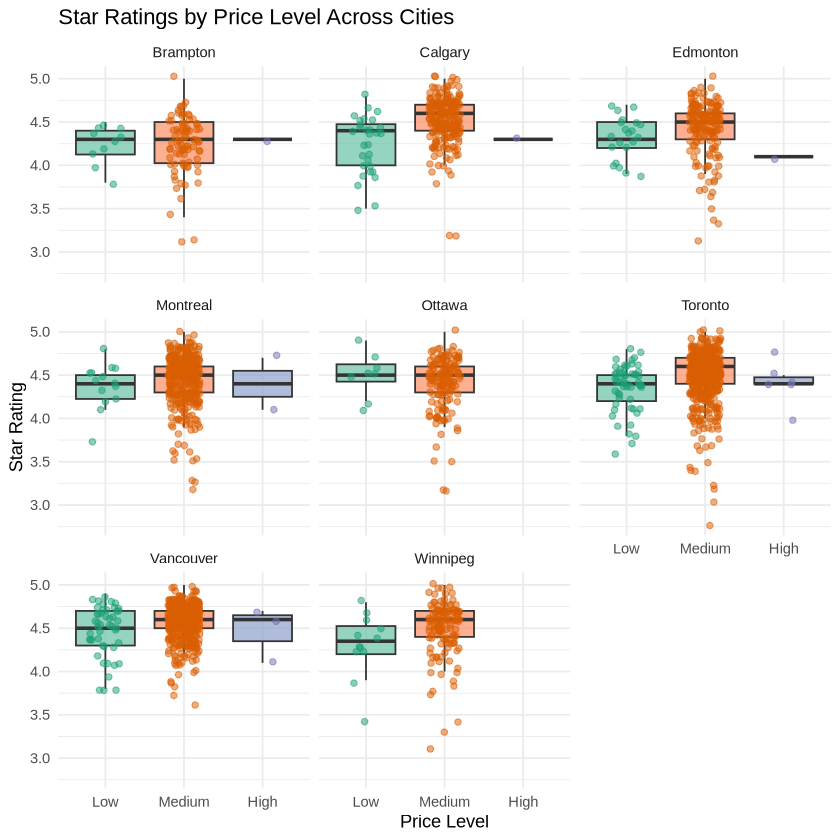

In [21]:
# Build boxplot of star ratings by price level
ggplot(door_dash_cleaned, aes(x = price_level, y = star, fill = price_level)) +

# Add boxplot without outliers and transparency
  geom_boxplot(outlier.shape = NA, alpha = 0.7) +

# Add jittered points for individual ratings, colored by price level
  geom_jitter(aes(color = price_level), width = 0.2, alpha = 0.5, size = 1.5) +

# Facet the plot by city
  facet_wrap(~ city) +

# Add colors
  scale_fill_brewer(palette = "Set2") +
  scale_color_brewer(palette = "Dark2") +

 # Add titles and labels
  labs(
    title = "Star Ratings by Price Level Across Cities",
    x = "Price Level",
    y = "Star Rating"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

This plot shows the **star ratings** for restaurants across three **price levels** (`Low`, `Medium`, `High`) in different cities.

- **General Trend**: Higher-priced restaurants tend to have higher star ratings, with most **High-price** restaurants rating around **4.5** or higher.

- **Outliers**: Some **Low-price** restaurants have higher ratings than expected, showing variability in quality.

- **City Differences**: Cities like **Toronto** and **Ottawa** have a wider range of ratings, while cities like **Calgary** and **Vancouver** show more consistency.

Now, we are going to create a heatmap to examine the relationships between `num_reviews`, `star`, and `distance_in_meters`. This visualization helps identify any potential correlations between these variables, which could provide insights into patterns in restaurant reviews, ratings, and distances. 

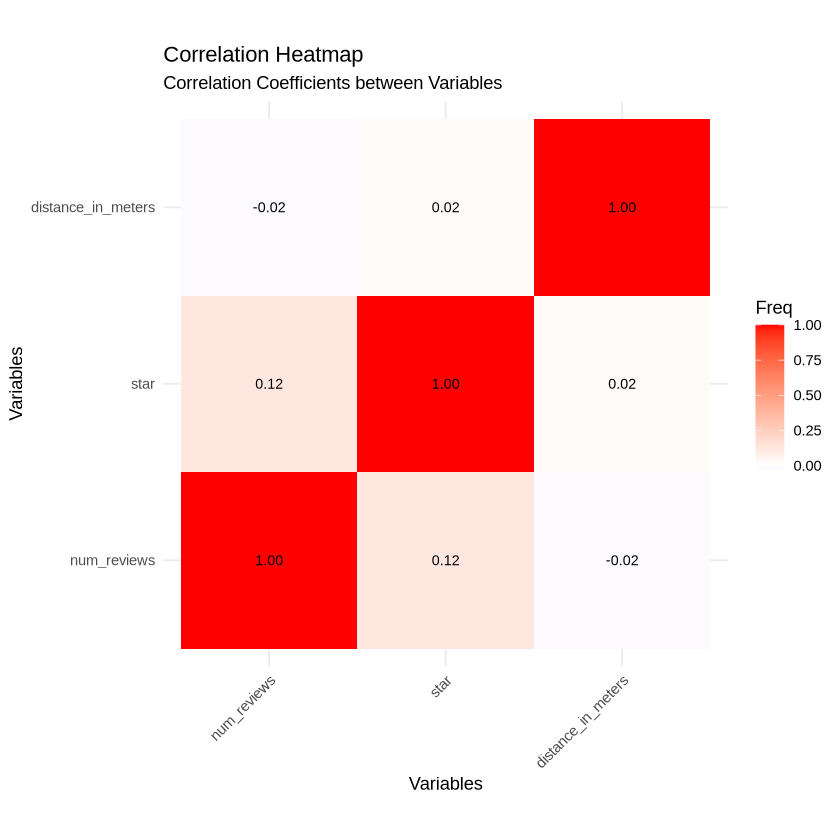

In [22]:
# Select the useful columns
numeric_data <- door_dash_cleaned %>%
  select(num_reviews, star, distance_in_meters)

# Generate the correlation matrix
correlation_matrix <- cor(numeric_data)

# Convert the correlation matrix to a data frame
correlation_df <- as.data.frame(as.table(correlation_matrix))

# Create the heatmap with no gaps between tiles
ggplot(correlation_df, aes(Var1, Var2, fill = Freq)) +
  geom_tile(width = 1, height = 1) +  # Set width and height to 1 to fill space
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0) +  # Color scale
  geom_text(aes(label = sprintf("%.2f", Freq)), color = "black", size = 3) +  # Show correlation coefficients
  theme_minimal() +
  labs(
    title = "Correlation Heatmap",
    subtitle = "Correlation Coefficients between Variables",
    x = "Variables",
    y = "Variables"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  # Rotate x-axis labels for readability
  coord_fixed(ratio = 1)  # Fix aspect ratio to make the tiles square

The heatmap shows that `num_reviews` and `star` have a mild positive correlation (**0.12**), indicating that more reviews slightly correlate with higher ratings. `num_reviews` and `distance_in_meters` show a very weak negative correlation (**-0.02**), and `star` and `distance_in_meters` have a weak positive correlation (**0.02**), suggesting minimal impact of distance on reviews and ratings.

We want to create a **summary table** to show the count of observations for each combination of **price level** (`price_level`) and **city** (`city`). This helps us understand the distribution of data across these key categorical variables and identify any imbalances or patterns, such as overrepresented or underrepresented groups. This step is important for ensuring all groups are adequately represented before proceeding with further analysis or visualizations.

In [23]:
# Summary table: count of observations by price_level and city
summary_table <- door_dash_cleaned %>%
  group_by(price_level, city) %>%

# Calculate the count of observations in each group, removing the grouping structure
  summarize(count = n(), .groups = "drop")

summary_table

price_level,city,count
<fct>,<chr>,<int>
Low,Brampton,10
Low,Calgary,30
Low,Edmonton,21
Low,Montreal,14
Low,Ottawa,8
Low,Toronto,56
Low,Vancouver,47
Low,Winnipeg,12
Medium,Brampton,82


The summary table shows the count of observations for each combination of **price level** and **city**:

- **Low price level**: **Toronto** (56), **Vancouver** (47), and **Calgary** (30) have the most low-priced restaurants, while **Ottawa** (8) and **Winnipeg** (12) have fewer.

- **Medium price level**: **Toronto** (485) and **Vancouver** (412) dominate, with **Montreal** (375) and **Ottawa** (155) also having significant numbers.

- **High price level**: Very few high-priced restaurants are present, with **Toronto** (6) and **Montreal** (2) leading.

Overall, the dataset has more **Low** and **Medium** priced restaurants, with **High** priced ones being underrepresented, particularly in cities like **Brampton** and **Winnipeg**.

### Methods: Plan

## Discussion

## References

Satoshi_S. (2022). Food Delivery across Canada (Door Dash) (version 6) [Data set]. Kaggle. https://www.kaggle.com/datasets/satoshiss/food-delivery-in-canada-door-dash?select=doordash_Brampton_2022-06-02.csv.

SohamChakote (2025). doordash.csv [Data set]. GitHub. https://raw.githubusercontent.com/SohamChakote/STAT-301-Project/refs/heads/main/doordash.csv